## Análise de Resultados

In [1]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st

#sys.path.insert(0, os.path.dirname(__file__))


In [2]:
models_and_legend = {
  "____random_":           ["bandit_policy", "observation"],
  "____fixed_":            ["bandit_policy", "observation"],
  "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____model_":            ["bandit_policy","full_refit", "val_split_type"],
  "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
  "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
  "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
  "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
  "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
  "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
}

path = PATH_EVAL_REINFORCEMENT

In [3]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)

## Filter Data

In [4]:
city = "Rio de Janeiro, Brazil"
city = "Como, Italy"
city = "Chicago, USA"

df_params = load_iteractions_params(result_paths)
df_params = df_params[df_params['data_frames_preparation_extra_params.filter_city'] == city]
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,activation_function,balance_fields,bandit_policy,bandit_policy_params.alpha,bandit_policy_params.arg,bandit_policy_params.decay_rate,bandit_policy_params.epsilon,bandit_policy_params.exploration_threshold,bandit_policy_params.explore_rounds,bandit_policy_params.logit_multiplier,...,sampling_strategy,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,none,6,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,none,8,0.1,0,0.0,time,False,0.2,random,lecun_normal


In [45]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits

,bandit_policy,observation,iteraction,name,model
0,adaptive,,"[output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_f3f4bc96ca, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_c9a2106b16, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_ccda0e5519, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_411d00d36e, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_25eeef1241, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_703f577767, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_1805a03bf3, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_77f0fb14c4, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_cf9a362bac, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_8b0863a87e]",adaptive,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_25eeef1241
1,custom_lin_ucb,,"[output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_c6cb5d38da, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_2b0e7eda7e, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_b1a79ad944, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_3d25f184ae, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_eb4f96847c, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_c79f441189, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_178897b9db, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_73faccd2cb, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_609638d31b, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_f825bb29dc]",custom_lin_ucb,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_f825bb29dc
2,epsilon_greedy,,"[output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_388ee3a5c7, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_f7af9ca04d, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_61b715627f, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_641e45dd20, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_d72036d12e, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_dc05e1777b, output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_bbf0770e84, output/interaction_chicago/TrivagoLogisticModelIntera

## Geral

In [46]:
reward_metrics = []

In [47]:
for i, row in list_bandits.iterrows():
    df_metrics = get_metrics_reward(row['iteraction'])
    df_metrics['bandit'] = row['name']
    df_metrics['model']  = row['model']

    df_g_metrics = group_metrics(df_metrics)
    reward_metrics.append(df_g_metrics)

In [48]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
softmax_explorer,0.259617,0.013882,3431.100000,183.462046,10,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_8fcee14ca6
random,0.042222,NaN,558.000000,NaN,1,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_88b2d0895d
percentile_adaptive,0.261183,0.008483,3451.800000,112.107885,10,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____percentile_adapt_ccaf433ffc
model,0.324448,0.016204,4287.900000,214.145563,10,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____model_033f8a5517
lin_ucb,0.061483,0.001753,812.555556,23.168465,9,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_3f02c73d45
lin_ts,0.045097,0.001944,596.000000,25.694790,10,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ts_bf8d6e3013
fixed Popular Item,0.098517,NaN,1302.000000,NaN,1,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_603f5e460c
fixed First Item,0.255826,NaN,3381.000000,NaN,1,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_c755e18c94
explore_then_exploit,0.213983,0.007338,2828.000000,96.983389,10,output/interaction_chicago/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_199ff59574


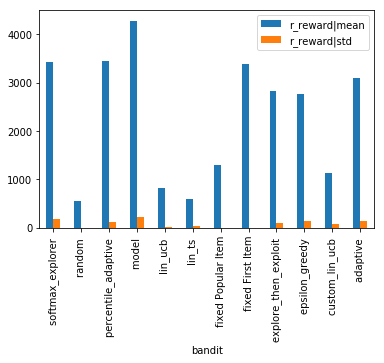

In [49]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [50]:
df_all.to_csv("output/tmp/stats.csv")

## Plot

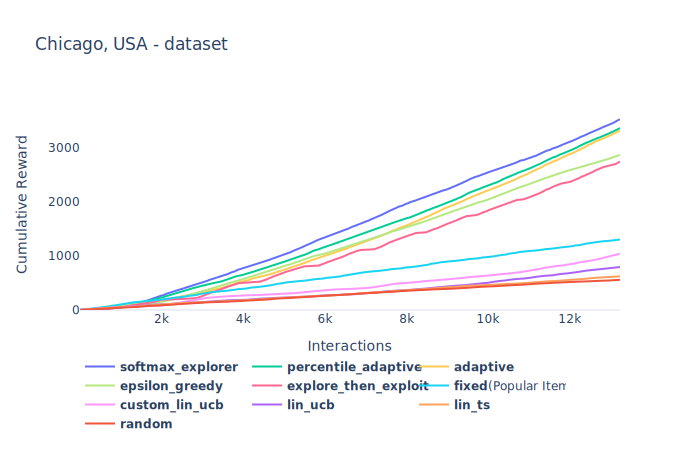

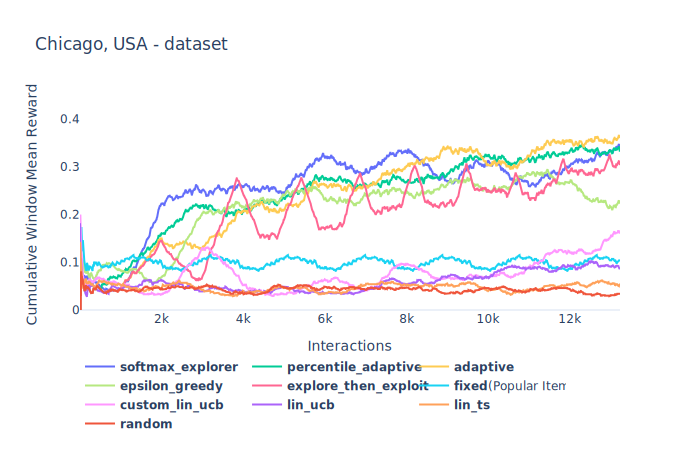

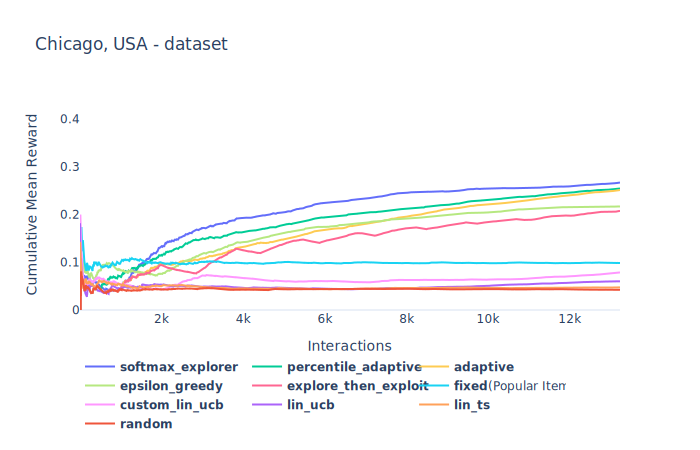

In [51]:

removed           = df_all.loc[['model ', 'fixed First Item']]['model|first'].values

input_legend      = ['bandit_policy', 'observation']
input_iteraction  = [p.split("/")[-1] for p in df_all['model|first'] if p not in removed]
sample_size       = 100000
window_size       = 1000 

st.set_option("client.displayEnabled", False)

metrics           = load_all_iteraction_metrics(input_iteraction, sample_size)
params            = load_iteractions_params2(input_iteraction)

df_metrics_reward = metrics.groupby("iteraction").agg({'reward': ['mean', 'sum']}).reset_index().sort_values([('reward', 'sum')], ascending=False)

df  = metrics.merge(params, on=['iteraction'], how='left')\
            .merge(metrics.groupby("iteraction")\
                    .agg({'reward': 'mean'})\
                    .rename(columns={'reward': 'sum_reward'})\
                    .reset_index(), 
              on=['iteraction'], how='left')\
            .reset_index()\
            .sort_values(['sum_reward', 'idx'], ascending=[False, True])

# GERAL
for input_metrics in ['Cumulative Reward', 'Cumulative Window Mean Reward', 'Cumulative Mean Reward']:
    #input_metrics = 'Cumulative Mean Reward'
    fig = plot_line_iteraction(df, 'reward', 
                          title=input_metrics, 
                          legend=input_legend,
                          yrange=[0, 0.4], 
                          line_dict=get_colors(input_iteraction),
                          window=window_size,
                          cum=(input_metrics == 'Cumulative Reward'), 
                          mean=(input_metrics == 'Cumulative Mean Reward'),
                          roll=(input_metrics == 'Cumulative Window Mean Reward'))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, title="{} - dataset".format(city))
    fig.show(renderer="svg")

    fig.write_image("output/tmp/iteraction_{}.eps".format(input_metrics.replace(" ", "_"))) #, width=1024, height=600, scale=2